In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
from pathlib import Path
import xtrack as xt
import xpart as xp
import xcoll as xc
import xobjects as xo
from matplotlib import colormaps

In [2]:
def generate_multivariate_uniform_ring(
        ndims: int, 
        nsamples: int=1, 
        inner_radius: float=0.0, 
        outer_radius:float=1.0
        ):
    
    nsamples = int(nsamples)

    _ = np.random.normal(size=(nsamples, ndims))
    _ = _ / np.linalg.norm(_, axis=-1, keepdims=True)
    __ = np.random.uniform(size=(nsamples, ))
    __ = (__ * (outer_radius**ndims - inner_radius**ndims) + inner_radius**ndims)**(1/ndims)

    return _ * __[:, None]

In [3]:
num_particles = 600
# num_turns = 6000
num_turns = 6000
plane = 'DPneg'
sweep = 6000
sweep = -abs(sweep) if plane == 'DPpos' else abs(sweep)
sweep_per_turn = sweep / num_turns
nemitt_x = 2e-6
nemitt_y = 2e-6
num_turns = 1_000_000

In [4]:
line = xt.Line.from_json('../../injection_lines/sps_q20_inj.json')
tt = line.get_table()
tw = line.twiss()

context = xo.ContextCpu()
line.vars['qph_setvalue'] = 0.5
line.vars['qpv_setvalue'] = 0.5
line.vars['qh_setvalue'] = line.vars['qx0']._value + 0.05
line.vars['qv_setvalue'] = line.vars['qy0']._value + 0.05

cavity_elements, cavity_names = line.get_elements_of_type(xt.Cavity)

for name in cavity_names:
    line[name].frequency = 200e6
    line[name].lag = 180
line['acl.31735'].voltage = 0 #setting 800 cav to 0V
line['actcse.31632'].voltage = 3.0e6

Loading line from dict:   0%|          | 0/4037 [00:00<?, ?it/s]

Done loading line from dict.           


In [5]:
env = line.env
# monitor1 = xt.ParticlesMonitor(start_at_turn=0, stop_at_turn=num_turns, n_repetitions=1, repetition_period=10000, particle_id_range=(num_particles-5, num_particles))
# monitor2 = xt.ParticlesMonitor(num_particles=num_particles, start_at_turn=0, stop_at_turn=num_turns)
monitor3 = xt.ParticlesMonitor(num_particles=num_particles, start_at_turn=0, stop_at_turn=num_turns)

# env.elements['monitor_qd31110'] = monitor1
# env.elements['monitor_qf31010'] = monitor2
env.elements['monitor_start'] = monitor3
# line.insert([env.place('monitor_qd31110', at='qd.31110@end'), env.place('monitor_qf31010', at='qf.31010@end'), env.place('monitor_start', at=0)])
line.insert([env.place('monitor_start', at=0)])

Slicing line:   0%|          | 0/3848 [00:00<?, ?it/s]

In [24]:
p = generate_multivariate_uniform_ring(5, num_particles, 0.0, 30)

In [25]:
part = line.build_particles(
    x_norm=p[:,0], px_norm=p[:,1],
    y_norm=p[:,2], py_norm=p[:,3],
    zeta_norm=p[:,4],
    nemitt_x=2e-6, nemitt_y=2e-6, # normalized emittances
    )

In [27]:
line.discard_tracker()
line.build_tracker(_context=xo.ContextCpu(omp_num_threads='auto'))

line.track(part, num_turns=num_turns, time=True, with_progress=True)

Compiling ContextCpu kernels...


ld: warning: duplicate -rpath '/Users/lisepauwels/miniforge3/envs/xcoll/lib' ignored
ld: warning: duplicate -rpath '/Users/lisepauwels/miniforge3/envs/xcoll/lib' ignored


Done compiling ContextCpu kernels.


Tracking:   0%|          | 0/1000000 [00:00<?, ?it/s]

In [ ]:
dict_monitor={'x' : monitor3.x.tolist(), 'y' : monitor3.y.tolist(), 'px' : monitor3.px.tolist(), 'py' : monitor3.py.tolist(), 'zeta' : monitor3.zeta.tolist(), 'delta' : monitor3.delta.tolist(), 'state': monitor3.state.tolist()}
part.to_json('dynamic_aperture_part.json', indent=4)
import json
with open(f'dynamic_aperture_mon.json', 'w') as fout:
    json.dump(dict_monitor, fout, indent=4)

KeyboardInterrupt: 

In [44]:
part_init = line.build_particles(
    x_norm=p[:,0], px_norm=p[:,1],
    y_norm=p[:,2], py_norm=p[:,3],
    zeta_norm=p[:,4],
    nemitt_x=2e-6, nemitt_y=2e-6, # normalized emittances
    )

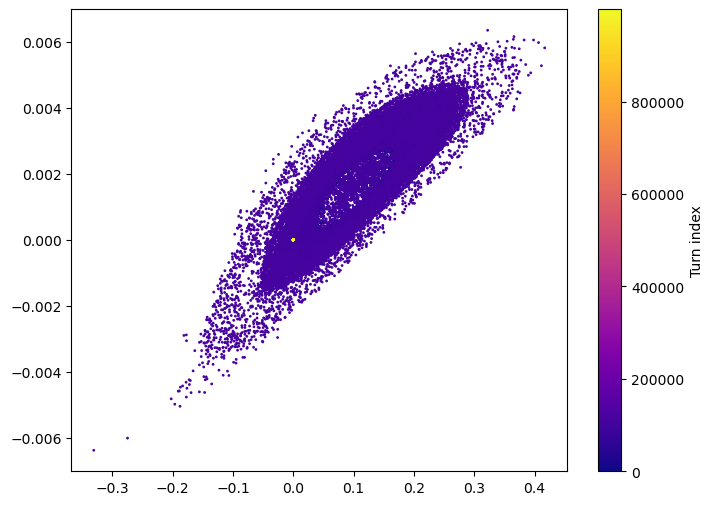

In [51]:
fig, ax = plt.subplots(1,1, figsize=(8,6))
pid = 60
sc = ax.scatter(
    monitor3.x[pid,:], monitor3.px[pid,:],
    c=np.arange(num_turns),
    s=1,
    cmap='plasma',      # or any colormap
    rasterized=True      # optional: makes large scatter MUCH faster in PDFs
)

fig.colorbar(sc, ax=ax, label='Turn index')

In [48]:
np.trim_zeros(monitor3.x[pid,:])

array([-0.01644808,  0.08975244,  0.20697921, ...,  0.20268492,
       -0.27477954, -0.33073482], shape=(115905,))

In [52]:
part.sort(interleave_lost_particles=True)

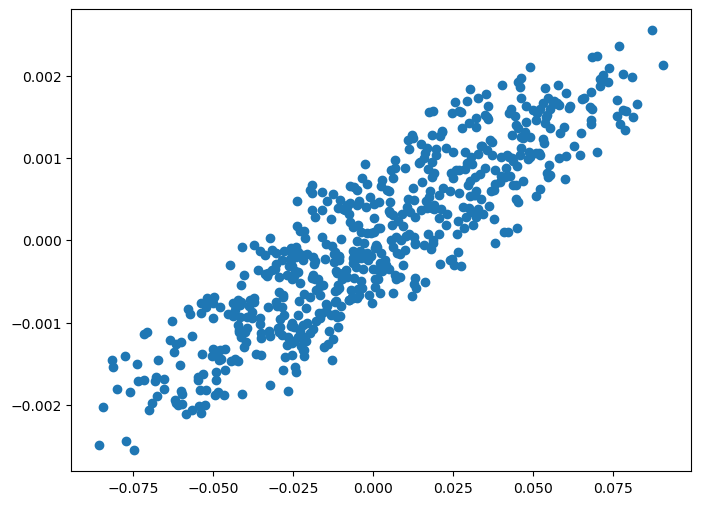

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(8,6))

ax.scatter(
    part_init.x, part_init.px,)